## Giới thiệu về Naive Bayes
Với sự gia tăng trong việc tiêu thụ sản phẩm và dịch vụ trực tuyến, người tiêu dùng đang phải đối mặt với một vấn đề lớn về sự tràn ngập của các tin nhắn rác trong hộp thư đến của họ, hoặc là dựa trên quảng cáo hoặc là gian lận. Nhưng do đó, các tin nhắn/Email có tầm quan trọng lớn bị đè bẹp dưới các tin nhắn rác.

Trong bài viết này, chúng ta sẽ tạo một mô hình phát hiện thư rác SMS giúp bạn xác định liệu một tin nhắn SMS có phải là thư rác hay không bằng cách sử dụng Naive Bayes và Xử lý ngôn ngữ tự nhiên (NLP).

### Đầu tiên, sẽ thu thập và tải dữ liệu

In [1]:
import pandas as pd
import numpy as np
df = pd.read_csv("spam.csv",encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


### Làm sạch dữ liệu


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [2]:
df.drop(columns=['Unnamed: 2','Unnamed: 3','Unnamed: 4'],inplace= True)
df.rename(columns={'v1':'message_type', 'v2':'message'},inplace=True)
df.sample(5)

,message_type,message
3821,ham,Just normal only here :)
1712,ham,o turns out i had stereo love on mi phone unde...
401,ham,Dear how is chechi. Did you talk to her
87,ham,Yes I started to send requests to make it but ...
3649,ham,"We are hoping to get away by 7, from Langport...."


Vì đây là vấn đề phân loại nên chúng ta muốn “message_type” được phân loại nhị phân, tức là 0 hoặc 1, do đó chúng ta sử dụng **label encoder**

In [3]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

In [4]:
df['message_type']=encoder.fit_transform(df['message_type'])
df.sample(5)

,message_type,message
4975,0,You are gorgeous! keep those pix cumming :) th...
3770,0,"Hi, wlcome back, did wonder if you got eaten b..."
1782,0,My uncles in Atlanta. Wish you guys a great se...
3838,0,Erm Û_ ill pick you up at about 6.45pm. That'...
3253,0,I can make lasagna for you... vodka...


In [5]:
label_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
print(label_mapping)

{'ham': np.int64(0), 'spam': np.int64(1)}


In [19]:
df[df['message_type']==1]

,message_type,message
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
5,1,FreeMsg Hey there darling it's been 3 week's n...
8,1,WINNER!! As a valued network customer you have...
9,1,Had your mobile 11 months or more? U R entitle...
11,1,"SIX chances to win CASH! From 100 to 20,000 po..."
...,...,...
5537,1,Want explicit SEX in 30 secs? Ring 02073162414...
5540,1,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...
5547,1,Had your contract mobile 11 Mnths? Latest Moto...
5566,1,REMINDER FROM O2: To get 2.50 pounds free call...


Now let’s check for the missing values

In [6]:
print(df.isnull().sum())
print(df.duplicated().sum())

message_type    0
message         0
dtype: int64
403


In [7]:
df= df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5169 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   message_type  5169 non-null   int64 
 1   message       5169 non-null   object
dtypes: int64(1), object(1)
memory usage: 121.1+ KB


## Exploratory Data Analysis
**Let’s visualise the classification problem to get a better understanding of the data.**

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

In [25]:
df['message_type'].value_counts()

message_type
0    4516
1     653
Name: count, dtype: int64

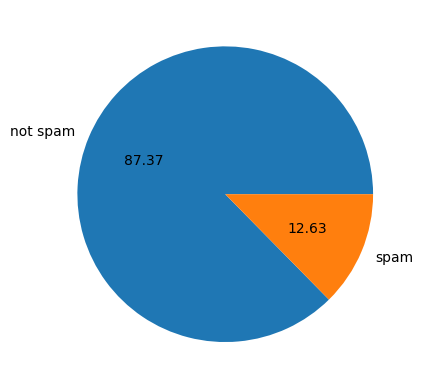

In [26]:
plt.pie(df['message_type'].value_counts(),labels=['not spam','spam'],autopct='%0.2f')
plt.show()

Đây là dữ liệu mất cân bằng

Bây giờ chúng ta hãy cùng tìm hiểu:

Số lượng ký tự trong dữ liệu
Số lượng từ trong dữ liệu
Số câu trong dữ liệu
và tạo 3 cột mới trong dữ liệu mô tả số lượng ký tự, từ và câu.

**Đối với một số ký tự:**

In [27]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [16]:
df['num_characters']=df['message'].apply(len)
df.head()

,message_type,message,num_words,num_characters
0,0,"Go until jurong point, crazy.. Available only ...",24,111
1,0,Ok lar... Joking wif u oni...,8,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,37,155
3,0,U dun say so early hor... U c already then say...,13,49
4,0,"Nah I don't think he goes to usf, he lives aro...",15,61


**Đối với một số từ:**

In [17]:
from nltk.tokenize import word_tokenize,sent_tokenize
df['num_words']=df['message'].apply(lambda x:len(word_tokenize(x)))
df.head()

,message_type,message,num_words,num_characters
0,0,"Go until jurong point, crazy.. Available only ...",24,111
1,0,Ok lar... Joking wif u oni...,8,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,37,155
3,0,U dun say so early hor... U c already then say...,13,49
4,0,"Nah I don't think he goes to usf, he lives aro...",15,61


**Đối với một số câu:**

In [18]:
df['num_sentences']=df['message'].apply(lambda x:len(sent_tokenize(x)))
df.head()

,message_type,message,num_words,num_characters,num_sentences
0,0,"Go until jurong point, crazy.. Available only ...",24,111,2
1,0,Ok lar... Joking wif u oni...,8,29,2
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,37,155,2
3,0,U dun say so early hor... U c already then say...,13,49,1
4,0,"Nah I don't think he goes to usf, he lives aro...",15,61,1


**Đối với tin nhắn Ham**

In [33]:
df[df['message_type']==0][['num_characters','num_words','num_sentences']].describe()

,num_characters,num_words,num_sentences
count,4516.000000,4516.000000,4516.000000
mean,70.459256,17.123782,1.820195
std,56.358207,13.493970,1.383657
min,2.000000,1.000000,1.000000
25%,34.000000,8.000000,1.000000
50%,52.000000,13.000000,1.000000
75%,90.000000,22.000000,2.000000
max,910.000000,220.000000,38.000000


**Đối với tin nhắn Spam**

In [34]:
df[df['message_type']==1][['num_characters','num_words','num_sentences']].describe()

,num_characters,num_words,num_sentences
count,653.000000,653.000000,653.000000
mean,137.891271,27.667688,2.970904
std,30.137753,7.008418,1.488425
min,13.000000,2.000000,1.000000
25%,132.000000,25.000000,2.000000
50%,149.000000,29.000000,3.000000
75%,157.000000,32.000000,4.000000
max,224.000000,46.000000,9.000000


### So sánh
1. Số ký tự (num_characters):

- Trung bình (mean): Tin nhắn spam có trung bình 137.89 ký tự, trong khi tin nhắn ham có trung bình 70.46 ký tự.
- Độ lệch chuẩn (std): Tin nhắn ham có độ lệch chuẩn cao hơn (56.36) so với tin nhắn spam (30.14), điều này cho thấy sự phân bố số lượng ký tự trong tin nhắn ham đa dạng hơn.
- Giá trị tối thiểu (min) và tối đa (max): Tin nhắn ham có giá trị tối thiểu là 2 ký tự và tối đa là 910 ký tự, trong khi tin nhắn spam có giá trị tối thiểu là 13 ký tự và tối đa là 224 ký tự.

2. Số từ (num_words):

- Trung bình (mean): Tin nhắn spam có trung bình 27.67 từ, trong khi tin nhắn ham có trung bình 17.12 từ.
- Độ lệch chuẩn (std): Tin nhắn ham có độ lệch chuẩn cao hơn (13.49) so với tin nhắn spam (7.01).
- Giá trị tối thiểu (min) và tối đa (max): Tin nhắn ham có giá trị tối thiểu là 1 từ và tối đa là 220 từ, trong khi tin nhắn spam có giá trị tối thiểu là 2 từ và tối đa là 46 từ.

3. Số câu (num_sentences):

- Trung bình (mean): Tin nhắn spam có trung bình 2.97 câu, trong khi tin nhắn ham có trung bình 1.82 câu.
- Độ lệch chuẩn (std): Tin nhắn ham có độ lệch chuẩn thấp hơn (1.38) so với tin nhắn spam (1.49).
- Giá trị tối thiểu (min) và tối đa (max): Tin nhắn ham có giá trị tối thiểu là 1 câu và tối đa là 38 câu, trong khi tin nhắn spam có giá trị tối thiểu là 1 câu và tối đa là 9 câu.

**Kết luận**

- Tin nhắn spam thường dài hơn tin nhắn ham, dựa trên số lượng ký tự, từ và câu trung bình.
- Tin nhắn ham có sự biến đổi lớn hơn về số lượng ký tự và từ, với phạm vi rộng hơn (min đến max).

Điều này có thể là do tin nhắn spam thường chứa nhiều thông tin hoặc nỗ lực để thuyết phục người nhận bằng cách sử dụng nhiều từ và câu hơn. Tin nhắn ham có thể ngắn gọn và trực tiếp hơn, nhưng cũng có thể có những tin nhắn rất dài tùy thuộc vào nội dung giao tiếp.

<Axes: xlabel='num_characters', ylabel='Count'>

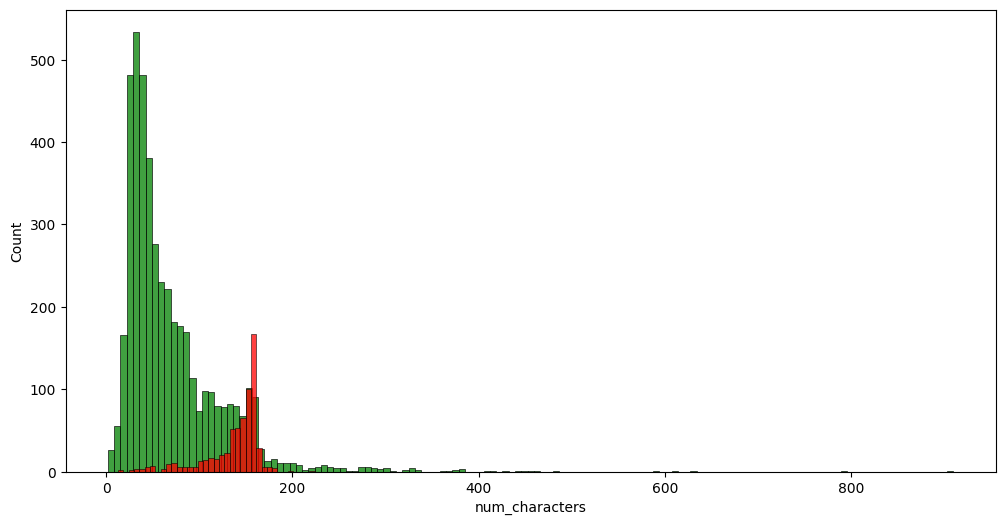

In [35]:
#for characters
plt.figure(figsize=(12,6))
sns.histplot(df[df['message_type']==0]['num_characters'],color='green')
sns.histplot(df[df['message_type']==1]['num_characters'],color = 'red')

<Axes: xlabel='num_words', ylabel='Count'>

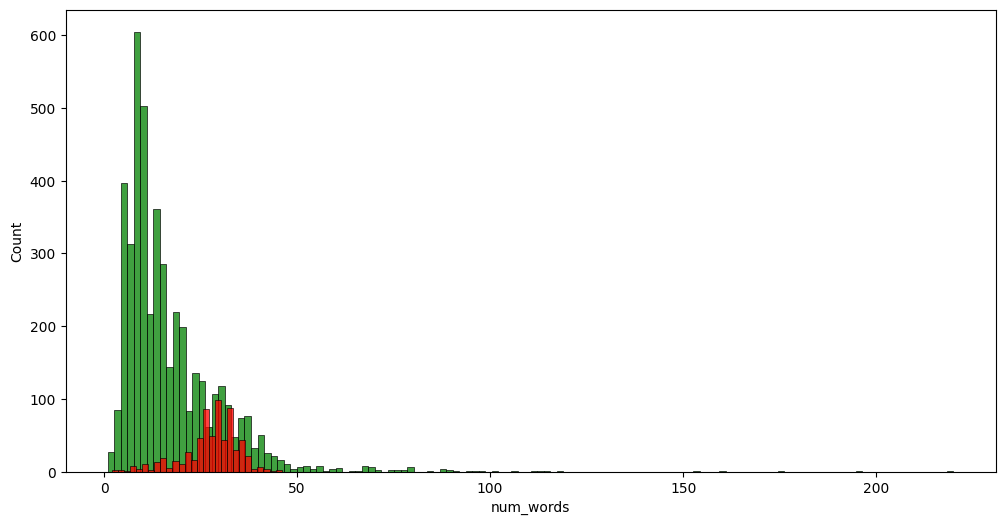

In [36]:
#for words
plt.figure(figsize=(12,6))
sns.histplot(df[df['message_type']==0]['num_words'],color='green')
sns.histplot(df[df['message_type']==1]['num_words'],color='red')

<Axes: >

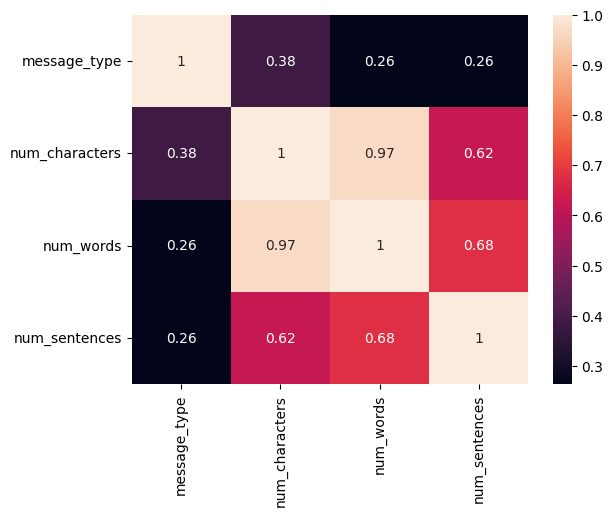

In [39]:
#plotting a heatmap for the correlation
sns.heatmap(df.select_dtypes(include=['number']).corr(),annot=True)

### Hiện tượng đa cộng tuyến là gì?
Đa cộng tuyến (multicollinearity) là hiện tượng xảy ra khi một hoặc nhiều biến độc lập trong mô hình hồi quy có mối tương quan tuyến tính cao với nhau. Điều này gây ra một số vấn đề:

1. Khó khăn trong việc ước lượng hệ số hồi quy: Do các biến độc lập có mối quan hệ mạnh với nhau, mô hình hồi quy không thể xác định một cách chính xác đóng góp riêng lẻ của từng biến độc lập. Điều này làm cho các hệ số hồi quy trở nên không ổn định và khó diễn giải.

2. Tăng phương sai của các hệ số hồi quy: Đa cộng tuyến làm tăng phương sai của các hệ số hồi quy, dẫn đến các ước lượng này trở nên không chính xác và không tin cậy.

3. Giảm khả năng giải thích của mô hình: Khi đa cộng tuyến xuất hiện, mô hình có thể trở nên phức tạp mà không thực sự cải thiện khả năng dự đoán, làm giảm hiệu quả của mô hình.

### Tại sao chọn mỗi cột num_characters để train model?
- Trong trường hợp này, việc chọn chỉ một biến có mối tương quan cao nhất với biến mục tiêu (message_type) giúp tránh hiện tượng đa cộng tuyến và giữ cho mô hình đơn giản, dễ hiểu hơn. Cụ thể, bạn chọn num_characters vì:

- Mối tương quan cao nhất với biến mục tiêu: num_characters có mối tương quan cao nhất với message_type, có nghĩa là nó mang lại nhiều thông tin nhất để dự đoán biến mục tiêu. Sử dụng biến này có thể giúp mô hình đạt được hiệu quả tốt hơn.

- Giảm đa cộng tuyến: Bằng cách chỉ sử dụng một biến, bạn loại bỏ hoàn toàn vấn đề đa cộng tuyến, vì không có biến nào khác để tạo ra mối quan hệ tuyến tính.

## Tiền xử lý dữ liệu
3.1. Chữ thường\
3.2. Mã hóa\
3.3. Xóa các ký tự đặc biệt\
3.4. Xóa bỏ các từ dừng và dấu câu\
3.5. Stemming — lemmatisation

In [29]:
from nltk.corpus import stopwords
stopwords.words('english')
len(stopwords.words('english')) 

179

In [30]:
#now for punctuation
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [31]:
# stemming
from nltk.stem.porter import PorterStemmer
ps =PorterStemmer()

In [32]:
def text_transform(message):
     # Chuyển về chữ thường và tách từ
    message = message.lower()
    message = word_tokenize(message)
    
    # Lọc các từ: loại bỏ stopwords, dấu câu và chỉ giữ lại từ alphanumeric
    stop_words = set(stopwords.words('english'))
    filtered_message = [ps.stem(word) for word in message if word.isalnum() and word not in stop_words and word not in string.punctuation]
    
    # Trả về kết quả dưới dạng chuỗi
    return " ".join(filtered_message)

In [33]:
df['transformed_msg']=df['message'].apply(text_transform)
df.head()

,message_type,message,num_words,num_characters,num_sentences,transformed_msg
0,0,"Go until jurong point, crazy.. Available only ...",24,111,2,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,8,29,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,37,155,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,13,49,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",15,61,1,nah think goe usf live around though


To get a clear idea about the most frequent words used we make a  word cloud.

Ảnh WordCloud này cung cấp một cách trực quan để bạn hiểu được các từ khóa phổ biến trong tin nhắn rác. Những từ lớn và nổi bật cho thấy các từ có tần suất xuất hiện cao, trong khi màu sắc có thể giúp làm nổi bật các yếu tố trực quan để dễ dàng phân tích các mô hình trong dữ liệu.

For Spam:

In [57]:
from wordcloud import WordCloud
size = 300
wc=WordCloud(width=size,height=size,min_font_size=10,background_color='white')

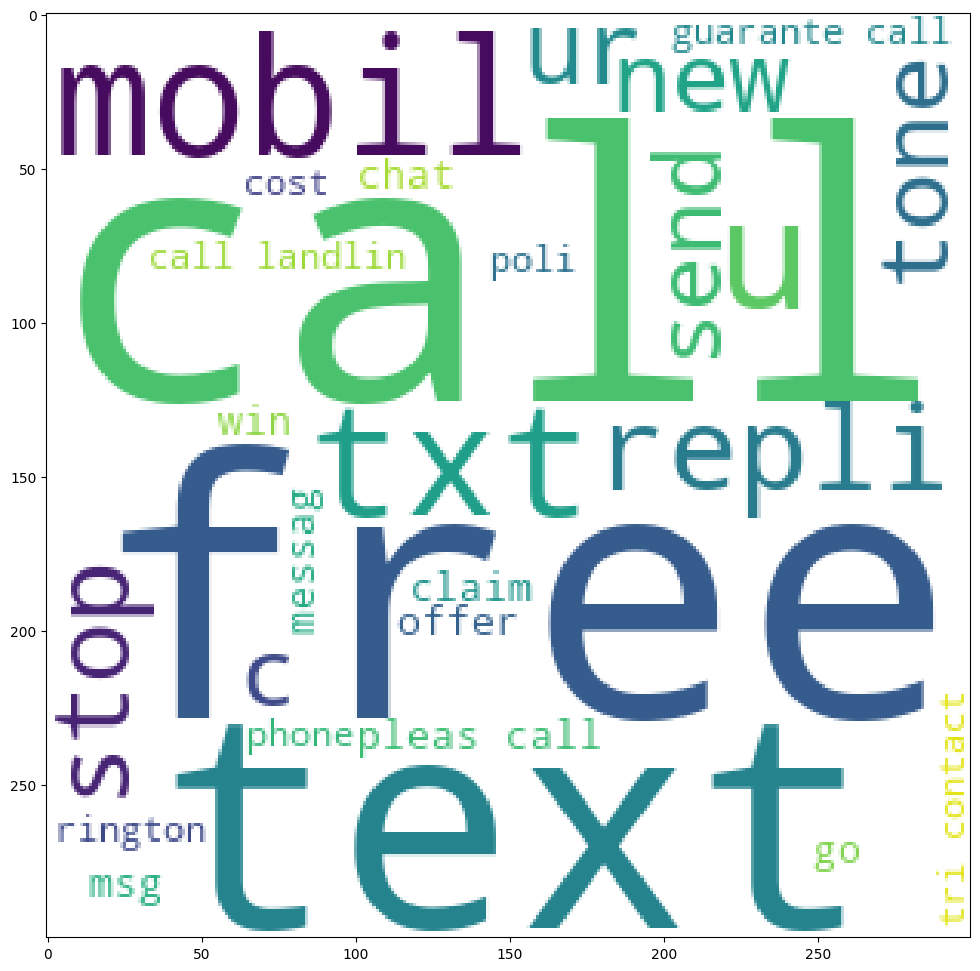

In [58]:
spam_wc=wc.generate(df[df['message_type']==1]['transformed_msg'].str.cat(sep=""))
plt.figure(figsize=(18,12))
plt.imshow(spam_wc)

For Ham:

Trong đoạn mã bạn cung cấp:

```python
ham_wc = wc.generate(df[df['message_type'] == 0]['transformed_msg'].str.cat(sep=""))
```

Phương thức **`.str.cat()`** là một phương thức trong pandas dùng để nối (concatenate) các chuỗi trong một cột của DataFrame thành một chuỗi duy nhất.

### Cách hoạt động của `.str.cat()`:

- **`df[df['message_type'] == 0]`**: Đây là cách bạn lọc ra các dòng có `message_type` bằng 0, tức là tin nhắn ham (non-spam).
- **`['transformed_msg']`**: Sau khi lọc, bạn chỉ chọn cột `transformed_msg`, đó là cột chứa các tin nhắn đã được xử lý (chuyển thành chữ thường, loại bỏ stopwords, ...).
- **`.str.cat(sep="")`**: 
  - **`.str.cat()`** là phương thức nối các chuỗi trong cột thành một chuỗi duy nhất.
  - **`sep=""`**: Đặt dấu phân cách (separator) là một chuỗi rỗng (`""`), có nghĩa là các tin nhắn trong cột `transformed_msg` sẽ được nối trực tiếp với nhau mà không có ký tự nào ở giữa.

Ví dụ:

Giả sử trong DataFrame bạn có ba tin nhắn:

- Tin nhắn 1: "hello world"
- Tin nhắn 2: "good morning"
- Tin nhắn 3: "how are you"

Khi bạn gọi `.str.cat(sep="")`, kết quả sẽ là một chuỗi duy nhất:

```
"hello worldgood morninghow are you"
```

Điều này sẽ giúp bạn tạo ra một chuỗi văn bản dài chứa tất cả tin nhắn ham để sử dụng trong việc tạo **WordCloud**.

### Tóm lại:
- **`.str.cat()`** nối tất cả các tin nhắn trong cột `transformed_msg` thành một chuỗi lớn.
- **`sep=""`** đảm bảo rằng không có ký tự nào được thêm vào giữa các tin nhắn khi nối chúng lại với nhau.

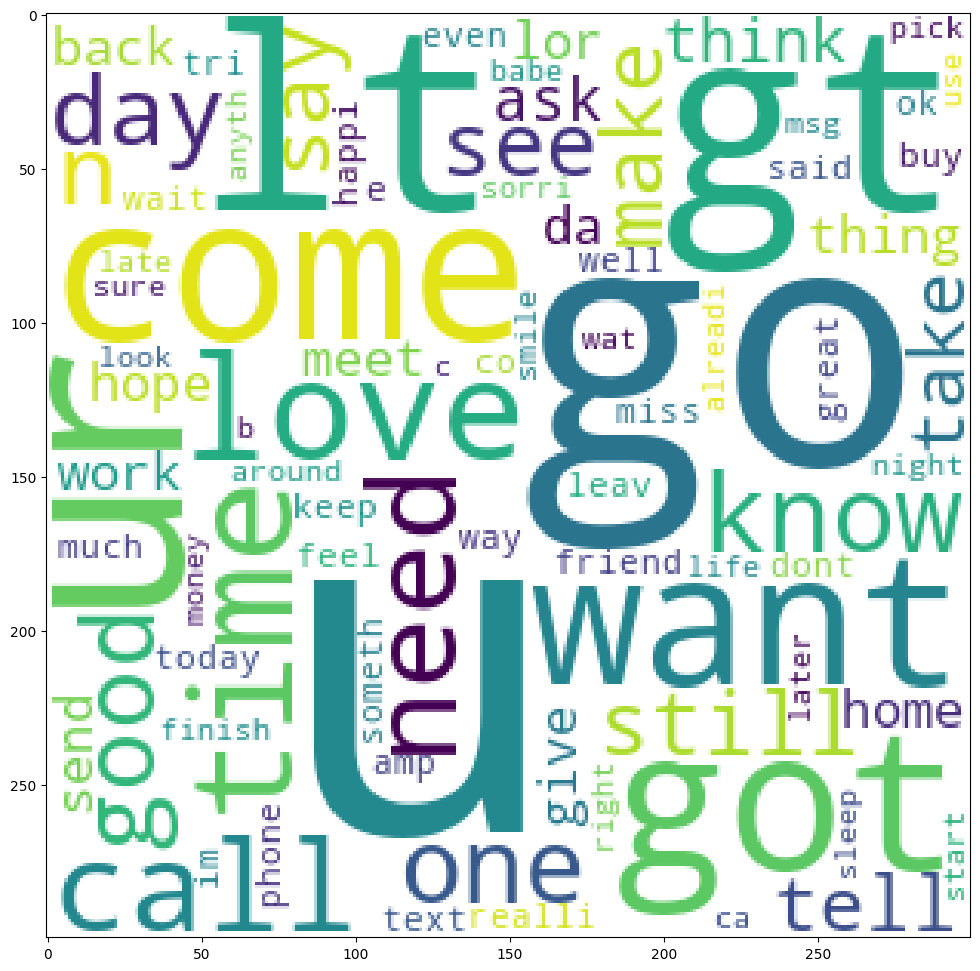

In [60]:
ham_wc = wc.generate(df[df['message_type']==0]['transformed_msg'].str.cat(sep=""))
plt.figure(figsize=(18,12))
plt.imshow(ham_wc)

## Building a Model using Naive Bayes

**Như đã biết, trên Dữ liệu văn bản, Thuật toán Naive Bayes hoạt động tốt nhất nên chúng ta sẽ sử dụng nó nhưng đồng thời cũng so sánh nó với các thuật toán khác**

Input is categorical Output is Numerical.

Nhưng như chúng ta đã biết trong thuật toán Naive Bayes, các cột đầu vào phải là số nên chúng ta phải chuyển đổi (VECTORIZE) cột.

### Cách vector hóa:\
- Túi từ ngữ\
- TFIDF\
- Word2vec\
Sau khi thử nhiều kỹ thuật khác nhau, tôi đi đến kết luận rằng vector hóa TFIDF mang lại độ chính xác và điểm số chính xác tốt nhất nên chúng tôi sẽ sử dụng kỹ thuật này.

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
gnb = GaussianNB()
bnb = BernoulliNB()
mnb = MultinomialNB()

In [35]:
tfidf= TfidfVectorizer(max_features=3000) #giới hạn số lượng từ khóa, giảm độ phức tạp của mô hình
X=tfidf.fit_transform(df['transformed_msg']).toarray()
y=df['message_type'].values

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=2)


| Actual \ Predicted | Spam (1)  True    | Ham (0)  False     |
|--------------------|---------------|---------------|
| Spam (1)   Negative        | **True Negative (TN)** = 790 | **False Negative (FN)** = 106 |
| Ham (0)    Positive        | **False Positive (FP)** = 24  | **True Positive (TP)** = 114 |

In [36]:
gnb.fit(X_train,y_train)
y_pred1= gnb.predict(X_test)
print('Accuracy score of Gaussian NB is: ',accuracy_score(y_test,y_pred1))
print('Confusion Matrix of Guassian NB is: ',confusion_matrix(y_test,y_pred1))
print('Precision score of the Gaussian NB is',precision_score(y_test,y_pred1))


Accuracy score of Gaussian NB is:  0.874274661508704
Confusion Matrix of Guassian NB is:  [[790 106]
 [ 24 114]]
Precision score of the Gaussian NB is 0.5181818181818182


| Actual \ Predicted | Spam (1)  True    | Ham (0)  False     |
|--------------------|---------------|---------------|
| Spam (1)   Negative        | **True Negative (TN)** = 896 | **False Negative (FN)** = 0 |
| Ham (0)    Positive        | **False Positive (FP)** = 30  | **True Positive (TP)** = 108 |

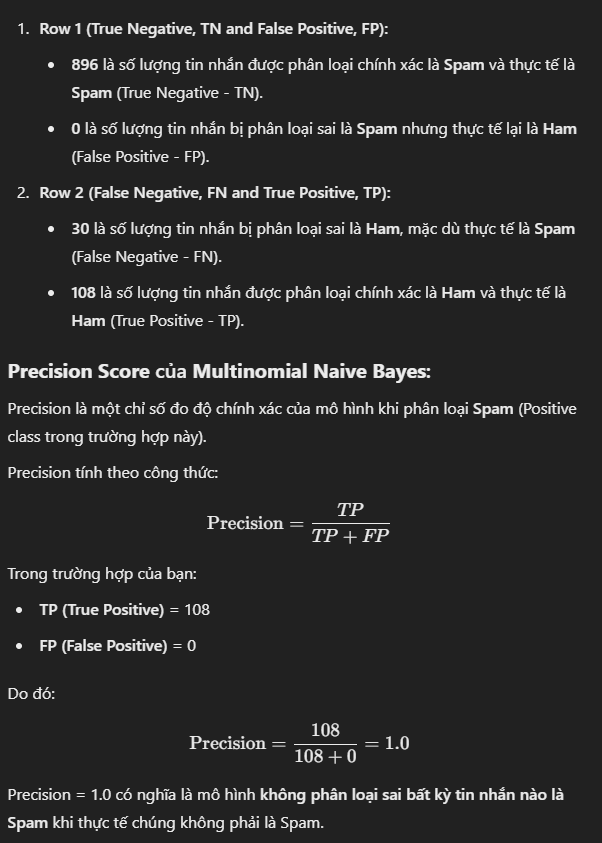

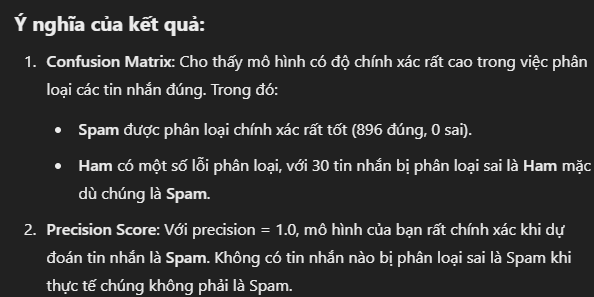

In [37]:
mnb.fit(X_train,y_train)
y_pred2=mnb.predict(X_test)
print('Accuracy score of Multinomial NB is: ',accuracy_score(y_test,y_pred2))
print('Confusion Matrix of Multinomial NB is: ',confusion_matrix(y_test,y_pred2))
print('Precision score of the Multinomial NB is',precision_score(y_test,y_pred2))


Accuracy score of Multinomial NB is:  0.9709864603481625
Confusion Matrix of Multinomial NB is:  [[896   0]
 [ 30 108]]
Precision score of the Multinomial NB is 1.0


| Actual \ Predicted | Spam (1)  True    | Ham (0)  False     |
|--------------------|---------------|---------------|
| Spam (1)   Negative        | **True Negative (TN)** = 895 | **False Negative (FN)** = 1 |
| Ham (0)    Positive        | **False Positive (FP)** = 16  | **True Positive (TP)** = 122 |

In [38]:
bnb.fit(X_train,y_train)
y_pred3=bnb.predict(X_test)
print('Accuracy score of Bernoulli NB is: ',accuracy_score(y_test,y_pred3))
print('Confusion Matrix of Bernoulli NB is: ',confusion_matrix(y_test,y_pred3))
print('Precision score of the Bernoulli NB is',precision_score(y_test,y_pred3))

Accuracy score of Bernoulli NB is:  0.9835589941972921
Confusion Matrix of Bernoulli NB is:  [[895   1]
 [ 16 122]]
Precision score of the Bernoulli NB is 0.991869918699187


## Building a website

In [66]:
import pickle
pickle.dump(tfidf,open('vectorizer.pkl','wb'))
pickle.dump(mnb,open('model.pkl','wb'))